### Libraries

In [63]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,  cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import AdditiveChi2Sampler
from sklearn.metrics import classification_report, confusion_matrix
import re, string, unicodedata
from scipy.sparse import hstack
from string import digits 
import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.fasttext import FastText

### Loading Data

Enumerate creates labels for Y and saves them in list "authors".
Articles texts are saved in articles list as separate strings.

In [2]:
#path of the current notebook('data' folder should be in the same folder as this notebook)
notebook_path = os.path.abspath("Εργασία 1(authorship attribution).ipynb")

data_folder = os.path.join(os.path.dirname(notebook_path), "data")

articles = []
authors  = []

subfolders = [subfolder for subfolder in os.listdir(data_folder) 
              if os.path.isdir(os.path.join(data_folder, subfolder))]

#for-loop to read every  txt in every subfolder
#enumerate creates the labels for Y, saves them in list "authors"
for author_number, subfolder in enumerate(subfolders):
    full_subfolder_path = os.path.join(data_folder, subfolder)
    for article_name in os.listdir(full_subfolder_path):
        with open(os.path.join(full_subfolder_path, article_name)) as f:
            articles.append(f.read().replace('\n', ' '))
            authors.append(author_number)
            



### Text Preprocessing

In [3]:
def remove_non_ascii(words):
    """Remove non-ASCII characters"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_newline(words):
    """remove \n """
    new_words = []
    for word in words:
        new_words.append(word.replace("\n"," "))
    return new_words


def remove_numbers(words):
    """Remove numbers"""
    new_words = []
    remove_digits = str.maketrans('', '', digits) 
    for word in words:
        new_words.append(word.translate(remove_digits))
    return new_words

def remove_special_chars(words):
    """Remove special characters"""
    new_words = []
    pattern = r'[\%&#@*$"()-]'
    for word in words:
        new_words.append(re.sub(pattern, ' ', word))
    return new_words

def remove_extra_whitespaces(words):
    """Remove extra whitespaces"""
    new_words = []
    for word in words:
        new_words.append(re.sub(' +', ' ', word))
    return new_words


def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_numbers(words)
    words = remove_newline(words)
    words = remove_special_chars(words)
    words = remove_extra_whitespaces(words)
    return words



In [64]:
#use normalize function we built to clean text
articles = normalize(articles)
#articles

In [5]:
#create dataframe to test enumeration
df = pd.DataFrame([articles,authors])
df = df.transpose()
df.columns = ['article', 'author number']
df.head(5)

,article,author number
0,the internet may be overflowing with new techn...,0
1,the u.s. postal service announced wednesday a ...,0
2,elementary school students with access to the ...,0
3,an influential internet organisation has backe...,0
4,an influential internet organisation has backe...,0


Train and test sets from the original dataset were merged so we can split them in a better way.
(original set had a 50-50 split)

In [6]:
#split data in 80-20 train-test
X_train, X_test, y_train, y_test = train_test_split(articles, authors, test_size = 0.2 , stratify = authors)

Testing different sizes of word and char n-grams using linear SVM.

In [8]:
#commented because it takes a lot of time to run. Results were saved in table below. 
#Uncomment to run(different rand seed might result in slighlty different results than those below)


# #test for different char n-grams:
# char_results = []
# char_feature = []

# for i in range(1,6):
#     char_vector = CountVectorizer(ngram_range=(i,i), analyzer = 'char')
#     tfidf_char_vector = TfidfVectorizer(ngram_range=(i,i), analyzer = 'char')
    
#     #simple char vectorizer
#     X_train_ngram = char_vector.fit_transform(X_train)
    
#     # char vectorizer with tfidf
#     X_train_tfidf = tfidf_char_vector.fit_transform(X_train)
    
#     clf= LinearSVC()
    
#     #cross validation(CV-3) for simple n-gram
#     cv_scores = cross_val_score(clf, X_train_ngram, y_train, cv=3, n_jobs=-1)
#     cv_mean_score = np.mean(cv_scores)
#     char_feature.append('{}{}'.format(i, '-gram'))
#     char_results.append(cv_mean_score)
    


#     #cross validation(CV-3) for tfidf n-gram
#     cv_scores = cross_val_score(clf, X_train_tfidf, y_train, cv=3, n_jobs=-1)
#     cv_mean_score = np.mean(cv_scores)
#     char_feature.append('{} {}{}'.format('tfidf', i, '-gram'))
#     char_results.append(cv_mean_score)
    
# d = {'feature': char_feature, 'cv-3 mean accuracy': char_results}
# char_ngram_results_df = pd.DataFrame(data = d)
# char_ngram_results_df 

### Character n-gram results

We commented the code for cross validation because it takes a long time to run. The results can be seen in the table below. You can change i range to a smaller number( 1,3 for example) to test the code.

|feature	     |cv-3 mean accuracy|
| :---           |             ---: |
|1-gram	         |0.125755          |
|tfidf 1-gram	 |0.306458          |
|2-gram	         |0.711443
|tfidf 2-gram	 |0.744349|
|3-gram          |	 0.821178|
|tfidf 3-gram    |	0.828481|
|4-gram	         |0.842583|
|tfidf 4-gram    |	0.829497|
|5-gram	         |0.841759|
|tfidf 5-gram	 |0.831652|


In [9]:
# #test for different word n-grams:
# word_results = []
# word_feature = []

# for i in range(1,4):
#     word_vector = CountVectorizer(ngram_range=(i,i), analyzer = 'word')
#     tfidf_word_vector = TfidfVectorizer(ngram_range=(i,i), analyzer = 'word')
    
#     #simple word vectorizer
#     X_train_ngram = word_vector.fit_transform(X_train)

#     # word vectorizer with tfidf
#     X_train_tfidf = tfidf_word_vector.fit_transform(X_train)

    
#     clf= LinearSVC()
    
#     #cross validation(CV-3) for simple n-gram
#     cv_scores = cross_val_score(clf, X_train_ngram, y_train, cv=3, n_jobs=-1)
#     cv_mean_score = np.mean(cv_scores)
#     word_feature.append('{}{}'.format(i, '-gram'))
#     word_results.append(cv_mean_score)
    


#     #cross validation(CV-3) for tfidf n-gram
#     cv_scores = cross_val_score(clf, X_train_tfidf, y_train, cv=3, n_jobs=-1)
#     cv_mean_score = np.mean(cv_scores)
#     word_feature.append('{} {}{}'.format('tfidf', i, '-gram'))
#     word_results.append(cv_mean_score)
    
# f = {'feature': word_feature, 'cv3 mean accuracy': word_results}
# word_ngram_results_df = pd.DataFrame(data = f)
# word_ngram_results_df 

### Word n-gram results



|feature	|cv3 mean accuracy|
|:--- | ---:|
|1-gram	|0.834359|
|tfidf 1-gram|	0.816828|
|2-gram|	0.841387|
|tfidf 2-gram	|0.840266|
|3-gram	|0.811073|
|tfidf 3-gram	|0.822934|

### Testing punctuation removal on character 4-grams

In [9]:
char_vector = CountVectorizer(ngram_range=(4,4), analyzer = 'char')
tfidf_char_vector = TfidfVectorizer(ngram_range=(4,4), analyzer = 'char')

#remove punctuation

X_train_nopunc = remove_punctuation(X_train)

#simple char vectorizer
X_train_ngram = char_vector.fit_transform(X_train_nopunc)

#char vectorizer with tfidf
X_train_tfidf = tfidf_char_vector.fit_transform(X_train_nopunc)

clf= LinearSVC()

#cross validation(CV-3) for simple n-gram
cv_scores = cross_val_score(clf, X_train_ngram, y_train, cv=3, n_jobs=-1)
cv_mean_score_ngram = np.mean(cv_scores)


#cross validation(CV-3 for tfidf n-gram
cv_scores = cross_val_score(clf, X_train_tfidf, y_train, cv=3, n_jobs=-1)
cv_mean_score_tfidf = np.mean(cv_scores)


In [10]:
print('char 4gram mean score without punctuation:',cv_mean_score_ngram)

char 4gram mean score without punctuation: 0.8260683760683761


In [11]:
print('char tfidf-4gram mean score without punctuation:',cv_mean_score_tfidf)

char tfidf-4gram mean score without punctuation: 0.8194776828110162


### Combining char 4-gram and and word 2-gram

In [13]:
word_vector = CountVectorizer(ngram_range=(2,2), analyzer = 'word')
char_vector = CountVectorizer(ngram_range=(4,4), analyzer = 'char')

#feature union combines 2 vectorizers results in 1 
vectorizer  = FeatureUnion([('char', char_vector),
                            ('word', word_vector)])

X_train_tf = vectorizer.fit_transform(X_train)

clf = LinearSVC()
cv_scores = cross_val_score(clf, X_train_tf, y_train, cv=3, n_jobs=-1)
cv_mean_score_ngram = np.mean(cv_scores)
print('char + word ngrams accuracy:', cv_mean_score_ngram)

char + word ngrams accuracy: 0.8364957264957265


Combining both word and char n-grams did not improve our model. We will use only character 4-grams and try to find the best classification algorithm.

### Rebuilding vocabulary and testing different algorithms

In [59]:
char_vector = CountVectorizer(ngram_range=(4,4), analyzer = 'char', max_features = None)
X_train_tf = char_vector.fit_transform(X_train)
X_test_tf = char_vector.transform(X_test)


In [60]:
len(char_vector.vocabulary_)

64063

### Multinomial Naive Bayes

In [14]:
clf_mnb = MultinomialNB()
mnb_cv_scores = cross_val_score(clf_mnb, X_train_tf, y_train, cv=3, n_jobs=-1)
mnb_cv_mean_score = np.mean(mnb_cv_scores)
print('CV-3 Accuracy', mnb_cv_scores)
print('Mean CV Accuracy:', mnb_cv_mean_score)
clf_mnb.fit(X_train_tf, y_train)
mnb_test_score = clf_mnb.score(X_test_tf, y_test)
print('Test Accuracy:', mnb_test_score)

CV-3 Accuracy [0.77037037 0.78148148 0.77461538]
Mean CV Accuracy: 0.7754890788224121
Test Accuracy: 0.815


### Logistic Regression

In [15]:
clf_lr = LogisticRegression(solver = 'lbfgs', multi_class = 'auto')
lr_cv_scores = cross_val_score(clf_lr, X_train_tf, y_train, cv=3, n_jobs=-1)
lr_cv_mean_score = np.mean(lr_cv_scores)
print('CV-3 Accuracy', lr_cv_scores)
print('Mean CV Accuracy:', lr_cv_mean_score)
clf_lr.fit(X_train_tf, y_train)
lr_test_score = clf_lr.score(X_test_tf, y_test)
print('Test Accuracy:', lr_test_score)

CV-3 Accuracy [0.82592593 0.84666667 0.83230769]
Mean CV Accuracy: 0.8349667616334283
Test Accuracy: 0.876


C:\Users\chris\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Random Forest

In [16]:
clf_rf = RandomForestClassifier(n_estimators = 100)
rf_cv_scores = cross_val_score(clf_rf, X_train_tf, y_train, cv=3, n_jobs=-1)
rf_cv_mean_score = np.mean(rf_cv_scores)
print('CV-3 Accuracy', rf_cv_scores)
print('Mean CV Accuracy:', rf_cv_mean_score)
clf_rf.fit(X_train_tf, y_train)
rf_test_score = clf_rf.score(X_test_tf, y_test)
print('Test Accuracy:', rf_test_score)

CV-3 Accuracy [0.73703704 0.76962963 0.75692308]
Mean CV Accuracy: 0.7545299145299146
Test Accuracy: 0.815


### Linear SVM

In [17]:
clf_linearSVC = LinearSVC()
linearSVC_cv_scores = cross_val_score(clf_linearSVC, X_train_tf, y_train, cv=3, n_jobs=-1)
linearSVC_cv_mean_score = np.mean(linearSVC_cv_scores)
print('CV-3 Accuracy', linearSVC_cv_scores)
print('Mean CV Accuracy:', linearSVC_cv_mean_score)
clf_linearSVC.fit(X_train_tf, y_train)
linearSVC_test_score = clf_linearSVC.score(X_test_tf, y_test)
print('Test Accuracy:', linearSVC_test_score)

CV-3 Accuracy [0.82444444 0.84444444 0.83923077]
Mean CV Accuracy: 0.836039886039886
Test Accuracy: 0.874


C:\Users\chris\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### SVM ( RBF Kernel)
commented due to very low accuracy and and very high training time

In [18]:
clf_SVC = SVC(gamma = 'auto', kernel = 'rbf')
SVC_cv_scores = cross_val_score(clf_SVC, X_train_tf, y_train, cv=3, n_jobs=-1)
SVC_cv_mean_score = np.mean(SVC_cv_scores)
print('CV-3 Accuracy', SVC_cv_scores)
print('Mean CV Accuracy:', SVC_cv_mean_score)
clf_SVC.fit(X_train_tf, y_train)
SVC_test_score = clf_SVC.score(X_test_tf, y_test)
print('Test Accuracy:', SVC_test_score)

CV-3 Accuracy [0.58814815 0.61407407 0.61      ]
Mean CV Accuracy: 0.6040740740740741
Test Accuracy: 0.702


### Knn

In [19]:
clf_knn = KNeighborsClassifier(n_neighbors=3)
knn_cv_scores = cross_val_score(clf_knn, X_train_tf, y_train, cv=3, n_jobs=-1)
knn_cv_mean_score = np.mean(knn_cv_scores)
print('CV-3 Accuracy', knn_cv_scores)
print('Mean CV Accuracy:', knn_cv_mean_score)
clf_knn.fit(X_train_tf, y_train)
knn_test_score = clf_knn.score(X_test_tf, y_test)
print('Test Accuracy:', knn_test_score)

CV-3 Accuracy [0.5562963  0.57185185 0.56846154]
Mean CV Accuracy: 0.5655365622032288
Test Accuracy: 0.631


### Multilayer Perceptron

2 hidden layers with 50 neurons each

In [20]:
mlp = MLPClassifier(solver='adam', activation = 'relu', hidden_layer_sizes=(50,50))
mlp.fit(X_train_tf, y_train)
mlp_cv_scores = cross_val_score(mlp , X_train_tf, y_train, cv=3, n_jobs=-1)
mlp_cv_mean_score = np.mean(mlp_cv_scores)
print('CV-3 Accuracy', mlp_cv_scores)
print('Mean CV Accuracy:', mlp_cv_mean_score)
mlp_test_score = mlp.score(X_test_tf, y_test)
print('Test Accuracy:', mlp_test_score)

CV-3 Accuracy [0.77851852 0.80962963 0.8       ]
Mean CV Accuracy: 0.7960493827160494
Test Accuracy: 0.854


## Results

In [21]:
df_results = pd.DataFrame([['Naive Bayes',mnb_cv_mean_score,mnb_test_score],
                           ['Logistic Regression',lr_cv_mean_score,lr_test_score],
                           ['Random Forest',rf_cv_mean_score,rf_test_score],
                           ['SVM(Linear)',linearSVC_cv_mean_score,linearSVC_test_score],
                           ['SVM(RBF)',SVC_cv_mean_score,SVC_test_score],
                           ['Knn',knn_cv_mean_score, knn_test_score],
                           ['MLP',mlp_cv_mean_score, mlp_test_score]],
                          columns = ['Algorithm', 'CV accuracy', 'Test set accuracy']
                          )

df_results

,Algorithm,CV accuracy,Test set accuracy
0,Naive Bayes,0.775489,0.815
1,Logistic Regression,0.834967,0.876
2,Random Forest,0.754530,0.815
3,SVM(Linear),0.836040,0.874
4,SVM(RBF),0.604074,0.702
5,Knn,0.565537,0.631
6,MLP,0.796049,0.854


## Optimizing SVM linear 

In [55]:
liblinear = LinearSVC(max_iter = 1000)
linear_param = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10]}
linear_clf = GridSearchCV(liblinear, linear_param, cv=3, scoring='accuracy', n_jobs= -1)
linear_clf.fit(X_train_tf, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [56]:
linear_clf.best_params_

{'C': 0.001}

In [57]:
linear_clf.cv_results_['mean_test_score'].mean()

0.836375

In [58]:
linear_clf.best_estimator_.score(X_test_tf, y_test)

0.878

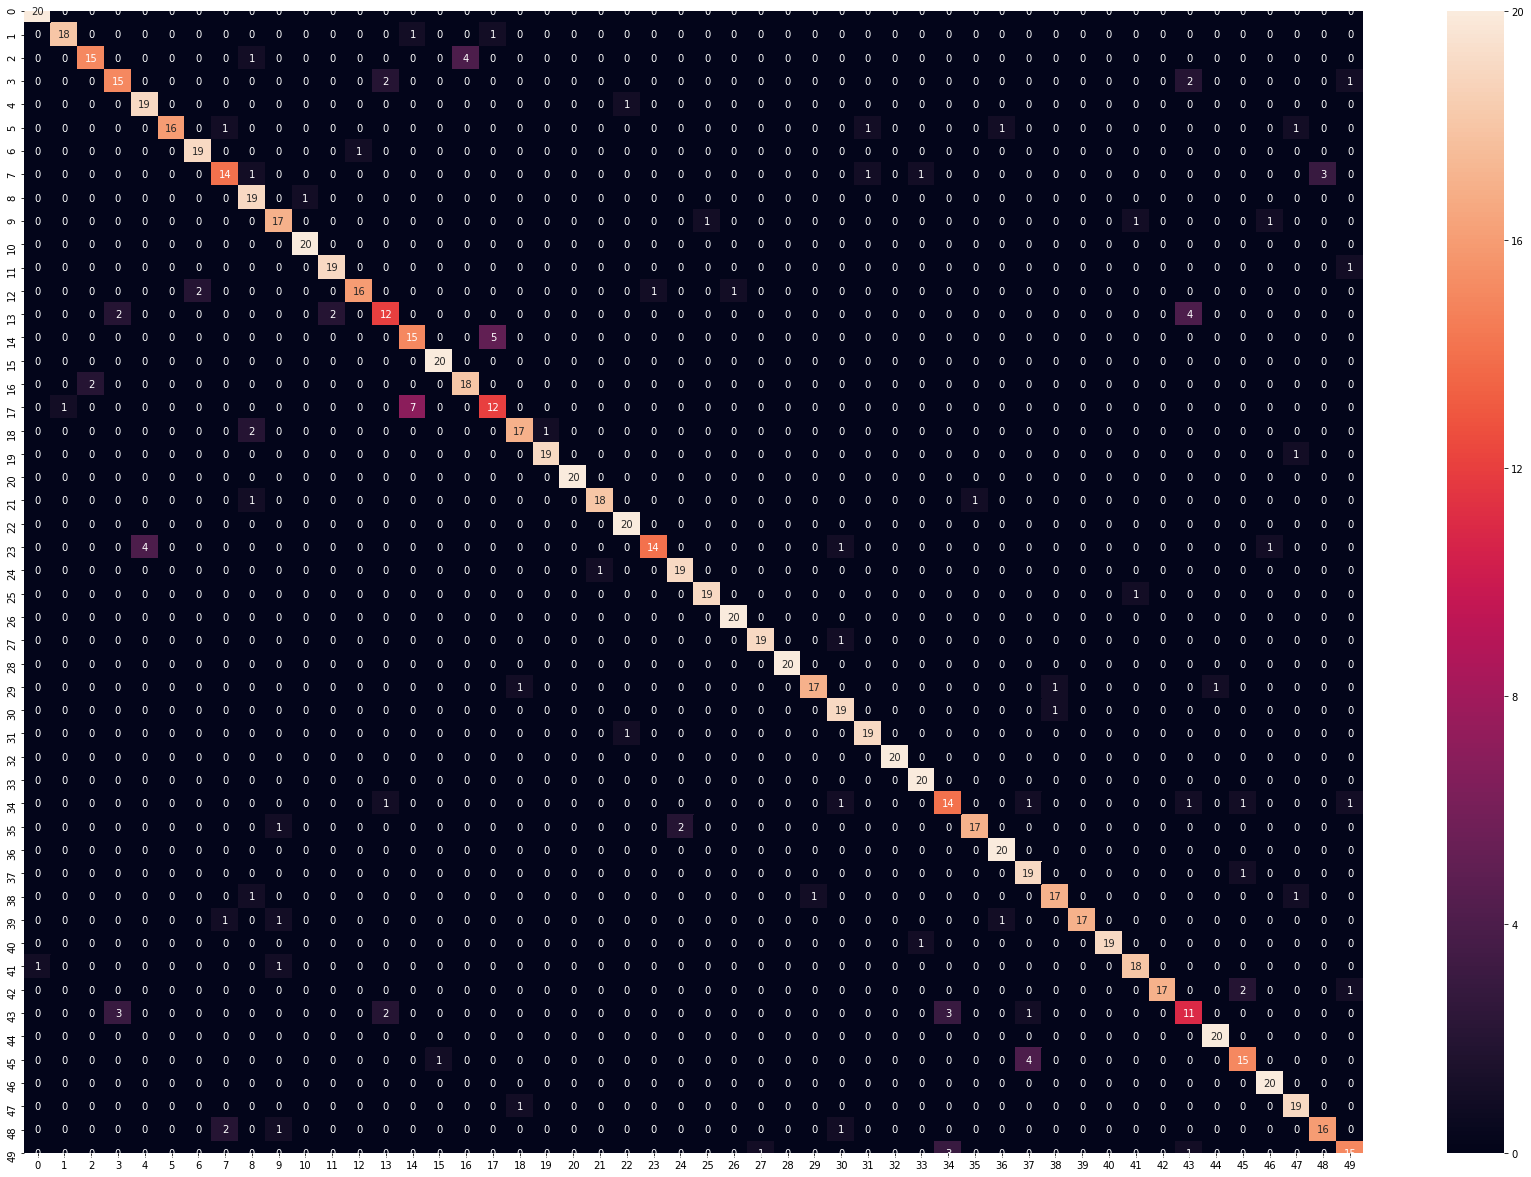

In [62]:
#confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cmatrix = confusion_matrix(y_true = y_test, y_pred = linear_clf.predict(X_test_tf)) 
df_cm = pd.DataFrame(cmatrix, index = [i for i in range(50)],
                  columns = [i for i in range(50)])
plt.figure(figsize = (30,21))
sn.heatmap(df_cm, annot=True)

### Linear SVM with different number of features(vocabulary size)

In [27]:
number_of_features = []
num_features_mean_score = []

for features_num in range(5000, 70000, 5000):
    char_vector = CountVectorizer(ngram_range=(4,4), analyzer = 'char', max_features = features_num)
    X_train_tf = char_vector.fit_transform(X_train)
    
    clf= LinearSVC(C = 0.001)

    #cross validation(CV-3) for simple n-gram
    cv_scores = cross_val_score(clf, X_train_tf, y_train, cv=3, n_jobs=-1)
    cv_mean_score = np.mean(cv_scores)
    number_of_features.append(features_num)
    num_features_mean_score.append(cv_mean_score)

    
g = {'number of features': number_of_features, 'cv3 mean accuracy': num_features_mean_score}
num_features_results_df = pd.DataFrame(data = g)
num_features_results_df

,number of features,cv3 mean accuracy
0,5000,0.832213
1,10000,0.835071
2,15000,0.836790
3,20000,0.838053
4,25000,0.839307
5,30000,0.838547
6,35000,0.838300
7,40000,0.838557
8,45000,0.838803
9,50000,0.838803


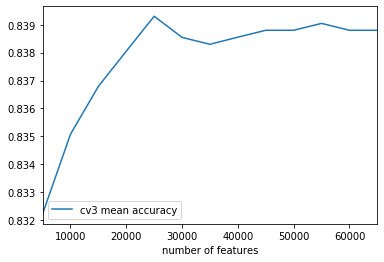

In [28]:
%matplotlib inline
num_features_results_df.plot(x = 'number of features', y = 'cv3 mean accuracy')

### POS ngrams

In [32]:
#rebuild vocabulary
char_vector = CountVectorizer(ngram_range=(4,4), analyzer = 'char', max_features = None)
X_train_tf = char_vector.fit_transform(X_train)
X_test_tf = char_vector.transform(X_test)

In [33]:
#create corpus to extract pos ngrams
corpus = []
for item in X_train:
    corpus.append(item)


In [34]:
#Tokenize strings to words and then find the pos_tags

def pos_tags(text):
    pos_tags = []
    for txt in text:
        #this solves an issue with blank strings
        if txt:
            words = word_tokenize(txt)
            pos_tags.append(" ".join(tag for (word,tag) in pos_tag(words) ))
    
    return pos_tags


X_train_tags = pos_tags(remove_punctuation(X_train))
            
X_test_tags  = pos_tags(remove_punctuation(X_test))        

In [35]:
# 3 word pos ngrams
postag_vector = TfidfVectorizer(ngram_range=(3,3), analyzer = 'word')
X_train_tag_tf = postag_vector.fit_transform(X_train_tags)
X_test_tag_tf  = postag_vector.transform(X_test_tags)

#char 4grams we used earlier
char_vector = CountVectorizer(ngram_range=(4,4), analyzer = 'char', max_features = None)
X_train_tf = char_vector.fit_transform(X_train)
X_test_tf = char_vector.transform(X_test)

#we cant use featureunion, we need to stack these 2 sparse matrices with hstack
X_train_final = hstack((X_train_tag_tf, X_train_tf), format = 'csr')
X_test_final  = hstack((X_test_tag_tf, X_test_tf), format = 'csr')




In [54]:
#linear SVC
clf_linearSVC = LinearSVC()
linearSVC_cv_scores = cross_val_score(clf_linearSVC, X_train_final, y_train, cv=3, n_jobs=-1)
linearSVC_cv_mean_score = np.mean(linearSVC_cv_scores)
print('CV-3 Accuracy', linearSVC_cv_scores)
print('Mean CV Accuracy:', linearSVC_cv_mean_score)
clf_linearSVC.fit(X_train_final, y_train)
linearSVC_test_score = clf_linearSVC.score(X_test_final, y_test)
print('Test Accuracy:', linearSVC_test_score)

CV-3 Accuracy [0.82444444 0.84444444 0.83923077]
Mean CV Accuracy: 0.836039886039886
Test Accuracy: 0.874


C:\Users\chris\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Word Embeddings

### Word2Vec

In [136]:
#tokenize corpus
X_train_words = [word_tokenize(text) for text in remove_punctuation(X_train)]
X_test_words = [word_tokenize(text) for text in remove_punctuation(X_test)]

In [208]:
# word2vec model
w2v_model = Word2Vec(X_train_words, size = 1000, window = 5 ,sg = 1, workers = 10)

In [209]:

def document_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0
        for word in words:
            if word in vocabulary:
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)
        return feature_vector
    features = [average_word_vectors(tokenized_sentence, model, vocabulary,
                                     num_features) for tokenized_sentence in corpus]
    return np.array(features)

#hard to converge, low accuracy
# def minmax_document_vectorizer(corpus, model , num_features):
#     vocabulary = set(model.wv.index2word)
#     def minmax_word_vectors(words,model, vocabulary, num_features):
#         feature_vector = np.zeros((2*num_features,), dtype="float64")
#         min_vector = np.zeros((num_features,), dtype="float64")
#         max_vector = np.zeros((num_features,), dtype="float64")
#         for word in words:
#             if word in vocabulary:
#                 max_vector = np.maximum(max_vector, model.wv[word])
#                 min_vector = np.minimum(min_vector, model.wv[word])
#         feature_vector  = np.concatenate((min_vector, max_vector),axis=None)
#         return feature_vector
    
#     features = [minmax_word_vectors(tokenized_sentence, model, vocabulary,
#                                      num_features) for tokenized_sentence in corpus]
#     return features
            

In [211]:
avg_wv_train_features = document_vectorizer(corpus = X_train_words, model = w2v_model , num_features = 1000)
avg_wv_test_features  = document_vectorizer(corpus = X_test_words, model = w2v_model , num_features = 1000)

In [212]:
clf = LinearSVC()
clf.fit(avg_wv_train_features, y_train)
clf.score(avg_wv_test_features, y_test)

0.72

In [204]:
#X_train_final = hstack((avg_wv_train_features, X_train_tf), format = 'csr')
#X_test_final  = hstack((avg_wv_test_features, X_test_tf), format = 'csr')

In [31]:
#clf = LinearSVC()
#clf.fit(X_train_final, y_train)
#clf.score(X_test_final, y_test)

### fastext

In [288]:
ft_num_features = 1000
# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = FastText(X_train_words, size=ft_num_features, window=5,
                    min_count=1, sg=1, iter=5, workers=10)

In [289]:
avg_ft_train_features = document_vectorizer(corpus = X_train_words, model = ft_model , num_features = 1000)
avg_ft_test_features  = document_vectorizer(corpus = X_test_words, model = ft_model , num_features = 1000)

In [290]:
clf = LinearSVC()
clf.fit(avg_ft_train_features, y_train)
clf.score(avg_ft_test_features, y_test)

0.728